# Welcome to Brancher
Brancher is a user-centered probabilistic differentiable programming library. Brancher is designed to be as beginner friendly as possible and to minimize boilerplate code while retaining all the power and flexibility of general-purpose differentiable probabilistic programming and deep learning. Brancher is built around the deep learning framework [PyTorch](https://pytorch.org/). 

In this notebook I will explain how to use Brancher for writing your own differentiable probabilistic program and perform variational inference in a/only few lines of code. Let's start by importing some modules!

In [ ]:
import sys
sys.path.append('/home/luca/GitRepositories/Brancher')

import torch
import matplotlib.pyplot as plt

from brancher.variables import ProbabilisticModel
from brancher.standard_variables import NormalVariable, LogNormalVariable
from brancher import inference
import brancher.functions as BF

Brancher is an object oriented library. This means that all objects in brancher are instantiation of classes that define the abstractions required for probabilistic programming. The foundamental building block of all Brancher programs is the RandomVariable class. probabilistic models are constructed by linking random variables through differentiable functions. RandomVariables are characterized by a probability distribution, a set of parent variables and a link that specifies how the values of the parents determine the parameters of its distribution.

For example, let's define a model where the mean of a normal random variable (mu) is determined by the sine of another normal random variable. Brancher allows you to define his model symbolically like you would do in a scientific paper:

In [2]:
# Model
nu = LogNormalVariable(loc=0., scale=1., name="nu")
mu = NormalVariable(loc=0., scale=10., name="mu")
x = NormalVariable(loc=BF.sin(mu), scale=nu, name="x")

You have to admit that this is a pretty clean sintax! The classes LogNormalVariable and  NormalVariable are subclasses of RandomVariables. The [log normal](https://en.wikipedia.org/wiki/Log-normal_distribution) variable is obtained by taking the exponential of a normal random variable. This is a known special case of the differentiable probabilistic programming approach of obtaining new probability distributions by applying differentiable functions on a small set of basic distributions such as the normal.

Let's now define a probabilistic model with all our variables:

In [3]:
model = ProbabilisticModel([x, mu, nu])

Since mu and nu are parents of x, ProbabilisticModel([x])

This expression is slightly reduntant because ProbabilisticModel([x]) already contains all the variables since mu and nu are parents of x. However, I recommend explicitly inputing all the variables for making your code more readable. 

We can now print a summary of our model:

In [4]:
model.model_summary

,nu,mu_loc,mu,mu_scale,x,nu_loc,nu_scale
Distribution,Log Normal,Deterministic,Normal,Deterministic,Normal,Deterministic,Deterministic
Parents,"{nu_scale, nu_loc}",{},"{mu_loc, mu_scale}",{},"{mu, nu}",{},{}
Observed,False,False,False,False,False,False,False


As we would expect, the variable x has mu and nu as parents. However, you might be surprised by the fact that there are new variables such as mu_mu and mu_sigma whioch we did not explicitly defined. These are deterministic variables that represent the fixed values of the parameters of our distribution. DeterministicVariables are a special case of BrancherVariables, they behave pretty much like RandomVariables expect their value being deterministic. As you can see, often you will not need to define these variables explicitly since Brancher will constract them for you when you input numbers or np.array as parameters for your RandomVariables.

All the variables are currently marked as not observed. We will see how to "observe" some variables by inputing data later on.

Let's now have a look to sampling: the most important operation you can do on probabilisticModels!

In [5]:
# Print samples
sample = model.get_sample(10)
sample

,mu_loc,mu_scale,mu,nu_scale,nu_loc,nu,x
0,0.0,9.999954,0.808285,0.541325,0.0,1.072378,1.486100
1,0.0,9.999954,12.279623,0.541325,0.0,0.610439,-0.703482
2,0.0,9.999954,-3.340621,0.541325,0.0,1.408964,-0.218620
3,0.0,9.999954,0.664779,0.541325,0.0,1.749260,0.684522
4,0.0,9.999954,-11.723947,0.541325,0.0,0.801317,0.593664
5,0.0,9.999954,-14.605591,0.541325,0.0,1.092042,1.203351
6,0.0,9.999954,6.438367,0.541325,0.0,2.631627,-0.901684
7,0.0,9.999954,22.934248,0.541325,0.0,6.181613,-13.972402
8,0.0,9.999954,-2.937538,0.541325,0.0,1.201508,-0.597040
9,0.0,9.999954,-0.122927,0.541325,0.0,3.239505,1.268376


As you can see, if we sample from the ProbabilisticModel we get samples for all the variables in our model. We can also sample from the individual variables:

In [6]:
# Print samples from single variable
x_sample = x.get_sample(10)
x_sample

,x
0,-0.387607
1,-6.187064
2,0.269301
3,0.113456
4,-2.858394
5,0.763187
6,-3.079767
7,0.313820
8,-1.482616
9,-0.887327


Note that Brancher is still sampling all the parents of x recursively (parents of the parents and so on) since it needs all these values for sampling x.

Another thing we can do is to sample after inputing the values of some variables. This converts the ProbabilisticModel into a random function that takes some input and output some samples with the probability distribution defined by the model:

In [7]:
# Print samples conditional on an input
in_sample = model.get_sample(10, input_values={mu: 100.})
in_sample

,mu,nu_scale,nu_loc,nu,x
0,100.0,0.541325,0.0,3.129300,2.300809
1,100.0,0.541325,0.0,5.791911,4.017151
2,100.0,0.541325,0.0,0.346305,0.246316
3,100.0,0.541325,0.0,0.222246,-0.057001
4,100.0,0.541325,0.0,0.338297,-0.853128
5,100.0,0.541325,0.0,0.478378,-0.717123
6,100.0,0.541325,0.0,2.187540,3.551509
7,100.0,0.541325,0.0,0.393402,-1.281143
8,100.0,0.541325,0.0,4.864683,7.547813
9,100.0,0.541325,0.0,0.396567,-1.021750


Note that this is equivalent to conditioning the model on the value of some variables and sampling everything downstream (children, grandchildren and so on). In order to sample upstream of some known values we need to define observation and use variational inference for getting an approximate posterior distribution. Let's begin by defining some ground truth values for the mu and nu variables and generate some synthetic observations:

In [8]:
# # Generate data
nu_real = 0.5
mu_real = -1.
data = x.get_sample(number_samples=100, input_values={mu: mu_real, nu: nu_real})

We can now tell Brancher that the x variable is observed with the values specified by our data. In this case data is a Pandas dataframe since it is the output of the get_sample method. However you can also input a single number or an np.array of any shape (the first dimension of the array is going to be the batch dimension while the other define tensor values observations).

In [9]:
# Observe data
x.observe(data)
model.model_summary

,nu,mu_loc,mu,mu_scale,x,nu_loc,nu_scale
Distribution,Log Normal,Deterministic,Normal,Deterministic,Normal,Deterministic,Deterministic
Parents,"{nu_scale, nu_loc}",{},"{mu_loc, mu_scale}",{},"{mu, nu}",{},{}
Observed,False,False,False,False,True,False,False


As you can see the x variable is now observed. If you want to sample the variables mu and nu that are downstream x you need to perform approximate Bayesian inference. In Brancher, you can do this by defining a variational distribution for all the variables you want to sample from. The variational model is a probabilistic model itself and it is constructed in the very same way of our original probabilistic model.

if you want to go deeper into the theory behind the variational approximation you can start with the [wikipedia page](https://en.wikipedia.org/wiki/Variational_Bayesian_methods) or excellent textbooks such as [Pattern recognition and machine learning](https://cds.cern.ch/record/998831/files/9780387310732_TOC.pdf).

The simplest way of specifying this distribution is the use the same distributions you had in your original model:

In [10]:
# Variational model
Qnu = LogNormalVariable(0., 1., "nu", learnable=True)
Qmu = NormalVariable(0., 1., "mu", learnable=True)
model.set_posterior_model(ProbabilisticModel([Qmu, Qnu]))

We now need to use some stochastic optimization (usual deep leaning stuff...) for learning the parameters of our variational approximation. This technique is called stochastic variational inference and it is extremely powerful since it neatly fit Bayesian inference into the deep learning framework (indeed brancher is designed to work with deep neural networks as building blocks for complex probabilistic models).

We told Brancher that the parameters of the variational distributions are learnable using the "learnable" flag. Let's now learn those parameters:

In [11]:
# Inference
inference.perform_inference(model,
                            number_iterations=500,
                            number_samples=50,
                            optimizer="Adam",
                            lr=0.01)
loss_list = model.diagnostics["loss curve"]

/home/luca/GitRepositories/Brancher/brancher/inference.py:61: UserWarning: The inference method was not specified, using the default reverse KL variational inference
  warnings.warn("The inference method was not specified, using the default reverse KL variational inference")
100%|██████████| 500/500 [00:02<00:00, 218.17it/s]


Et voilà, the approximate posterior distribution is trained. The number_samples parameter specify the minibatch size of the parameters sampled from the variational distribution. You need to know something about stochastic variational inference for fully getting this point and I will cover it more properly in more advanced tutorials.

Let's now plot the loss to be sure that everything went fine.

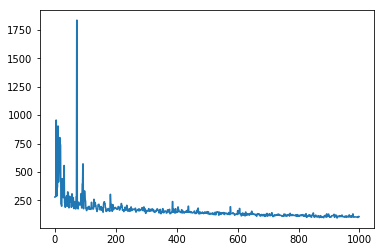

In [12]:
plt.plot(loss_list)

It looks ok! note however that this optimization can potentially get stuck in local minima like any other gradient based optimization so be careful. Stochastic variational inference is a powerful general purpose inference method but it does not do magic.

Let's now get some samples from the posterior:

In [13]:
# print posterior sample
post_sample = model.get_posterior_sample(1000)
post_sample.describe()

,mu,nu,x,mu_scale,mu_loc,nu_loc,nu_scale
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-1.132981,0.972926,-0.853557,-1.045208,-1.137778,-0.211238,-0.157409
std,0.303519,0.683251,1.207813,0.000000,0.000000,0.000000,0.000000
min,-2.211305,0.083033,-11.666206,-1.045208,-1.137778,-0.211238,-0.157409
25%,-1.340877,0.498089,-1.427967,-1.045208,-1.137778,-0.211238,-0.157409
50%,-1.129678,0.810982,-0.861622,-1.045208,-1.137778,-0.211238,-0.157409
75%,-0.923341,1.256558,-0.326371,-1.045208,-1.137778,-0.211238,-0.157409
max,-0.308253,5.927497,7.720804,-1.045208,-1.137778,-0.211238,-0.157409


The method describe gets some important descriptive statistics from the samples. It is just a native Pandas method and we can use it because the output of Brancher are Pandas dataframes. It is nice to work on the shoulders of other people isn't it?
 [Pandas](https://pandas.pydata.org/pandas-docs/stable/) has plenty of methods for working with data and I recommend you to use them in your Brancher pipelines! I suggest you to get started with Pandas with [this tutorial] (https://pandas.pydata.org/pandas-docs/stable/10min.html).

Let's now plot the posterior distributions together with the ground truth values:

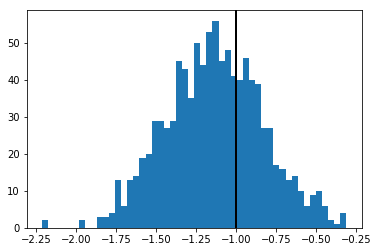

In [14]:
g = plt.hist(post_sample["mu"], 50)
plt.axvline(x=mu_real, color="k", lw=2)

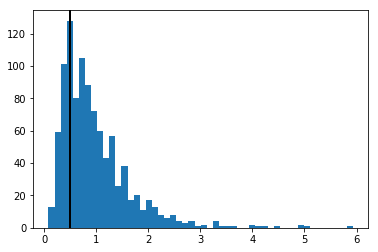

In [15]:
g = plt.hist(post_sample["nu"], 50)
plt.axvline(x=nu_real, color="k", lw=2)

We can visualize the posterior distribution using a Brancher plotting function. This function relies on [Seaborn](https://seaborn.pydata.org/), a very handy visualization library that works very well in combination with Pandas.

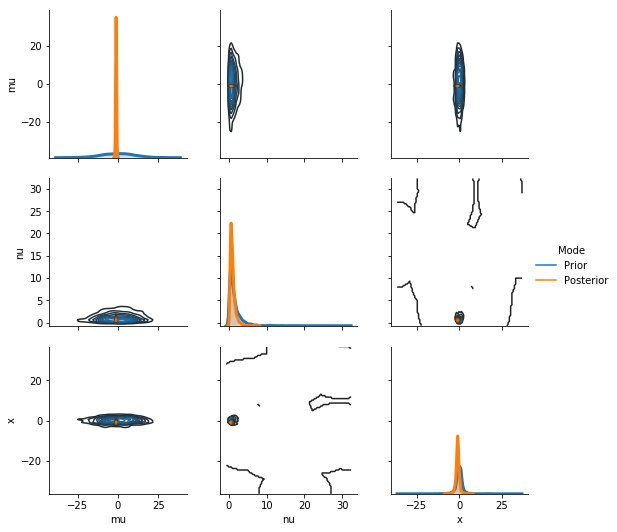

In [16]:
from brancher.visualizations import plot_posterior

plot_posterior(model, variables=["mu", "nu", "x"])

It looks cool doesn't it? 